##RNN. Seq2seq и Encoder-Decoder.

In [ ]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from typing import List

from sklearn.model_selection import train_test_split

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.processors import TemplateProcessing
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from random import choice
from tqdm.notebook import tqdm
%env CUDA_VISIBLE_DEVICES=0

from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_path = Path("/content/drive/MyDrive/Colab Notebooks/data").resolve()
encoded_images = np.load(data_path / "encoded_images.npy")

with (data_path / "captions.json").open("r", encoding="utf-8") as f:
    captions = json.load(f)

Убедимся, что векторы для всех изображений имеют размер 2048.

In [ ]:
print("Размерность всех данных", encoded_images.shape)
print(encoded_images[0, :10])

Размерность всех данных (118287, 2048)
[0.21027014 0.39289975 0.07608727 0.8199058  0.98774576 0.831893
 0.305828   0.19179453 0.4764485  0.1657095 ]


Каждое изображение имеет 5 вариантов текстового описания.

In [ ]:
print('\n'.join(captions[42]))

A street sign on a pole on a street.
Two green and white street signs with building in background.
A city street has an intersection sign on a pole.
Street signs near tall buildings on the corner of Greenwich St and Vesey St.
A Greenwich street and Vesey street sign are hanging on a pole.


Давайте попробуем прикинуть, сколько уникальных слов встречается в описаниях. Учтите, что слова могут быть в разном регистре и содержать знаки препинания при наивном разбиении по пробелу.

In [ ]:
word_set = set([
    tokens for img_captions in captions
    for caption in img_captions
    for tokens in caption.lower().split(" ")
])
print(len(word_set))

44830


Заметим, что слов очень много. На каждом шаге декодера нам приходиться решать задачу классификации на большое количество классов. А брать софтмакс от вектора такой большой размерности затруднительно. Поэтому имеется несколько вариантов: простой (1), очень простой (2) и современный (3) .

1. Отбросить редко встречающиеся слова (токены) и заменить их все на токен \<UNK\>.

2. Использовать в качестве токенов символы, а не слова. Такую модель мы использовали на семинаре для простой задачи генерации имён.
Этот подход имеет явный недостаток — модели, обучаемой на отдельных символах, гораздо сложнее выучить соотношения между буквами в каждом отдельном слове. Из-за этого может возникнуть ситуация, при которой значительная часть слов, сгенерированных моделью, не будут являться словами языка, на котором написаны входные тексты.

3. Использовать [Byte Pair Encoding](https://arxiv.org/pdf/1508.07909.pdf).

Разберём, как работает BPE на примере строки `aaabdaaabac`.
Пара `aa` встречается чаще всего, поэтому она будет заменяется символом `Z`, который не используется в данных, получается строка `ZabdZabac`.
Далее процесс повторяется для пары `ab`, которая заменяется на символ `Y`. Теперь строка имеет вид `ZYdZYac`, причем единственная оставшаяся пара исходных символов встречается только один раз. На этом кодировку можно остановить или же продолжать рекурсивно заменив `ZY` на `X`: `XdXac`. Полученную строку нельзя продолжать сжимать, поскольку не существует пары символов, встречающихся более одного раза. Для декодирования нужно выполнить замены в обратном порядке.

Если же мы будем проделывать эту процедуру не над маленькой строкой, а над большим датасетом, то мы найдем часто встречающиеся n-gram-ы из символов в датасете. Полученные замены будем использовать как новые токены и представлять каждое слово как последовательность таких токенов.
В данном случае получится, что частые слова скорей всего будут представлены лишь одним токеном, равным самому слову. А редкие слова разобъются на последовательность токенов, являющихся частыми.

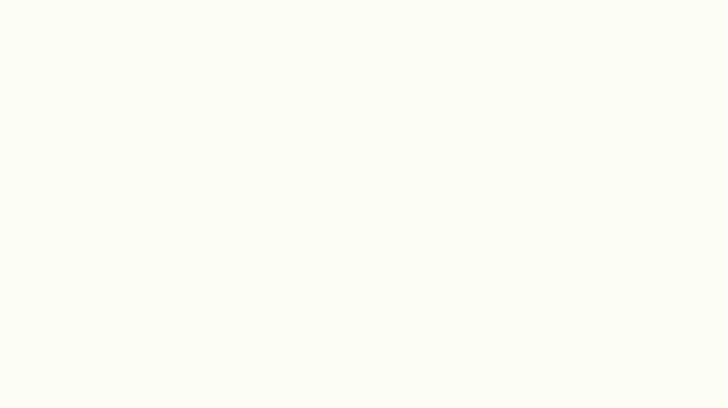

Метод BPE является некоторой золотой серединой между character-based и word-based подходами.

[`YouTokenToMe`](https://github.com/VKCOM/YouTokenToMe) — одна из опен-сорсных реализаций от разработчиков из VK.

[`tiktoken`](https://github.com/openai/tiktoken) – реализация BPE-токенизатора от OpenAI, который используется для их моделей.

[`SentencePiece`](https://github.com/google/sentencepiece) – реализация от Google.

[`tokenizers`](https://github.com/huggingface/tokenizers) – очень популярная реализация различных алгоритмов токенизации от HuggingFace.


Попробуем заиспользовать последнюю библиотеку и обучим собственный BPE-токенизатор. Для начала инициализируем объект нашего токенизатора.

In [ ]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

Создадим трейнер для последующего обучения. Ему можно указать такие параметры как размер словаря, а также спец. токены. Более подробно можно прочесть по [ссылке](https://huggingface.co/docs/tokenizers/en/api/trainers).

`[UNK]` — слово, не встречающееся в словаре; \
`[BOS]` — начало текста; \
`[EOS]` — конец текста; \
`[PAD]` — пустой токен.

In [ ]:
trainer = BpeTrainer(vocab_size=20_000,
                     special_tokens=["[UNK]", "[BOS]", "[EOS]", "[PAD]"])

Мы можем обучить наш токенизатор прямо сейчас, но это было бы не совсем грамотно. Без некоторй предварительной обработки, которая, например, разделила бы наши входные тексты на слова, мы могли бы получить токены, которые включают в себя несколько слов: например, мы могли бы получить токен `it is`, поскольку эти два слова часто появляются рядом друг с другом. Чтобы такого не произошло, зададим разбиение по пробелу как один из предварительных этапов обучения токенизатора.

In [ ]:
tokenizer.pre_tokenizer = Whitespace()

Приведем для простоты тексты к нижнему регистру, объединим в один список и обучим токенизатор на наших описаниях.

In [ ]:
merged_captions = [
    caption.lower()
    for img_captions in captions
    for caption in img_captions
]

tokenizer.train_from_iterator(
    merged_captions,
    trainer
)

Посмотрим на пример работы. Чтобы получить список токенов нужно позвать `.ids`.

In [ ]:
output = tokenizer.encode(merged_captions[42])
print(merged_captions[42])
print(f"Разбиение по токенам: {output.ids}")
print(f"Токены: {output.tokens}")
print(f"Начальный текст: {tokenizer.decode(output.ids)}")

output = tokenizer.encode("hello, y'all! how are you 😁 ?")
print(f"Разбиение по токенам: {output.ids}")
print(f"Токены: {output.tokens}")
print(f"Начальный текст: {tokenizer.decode(output.ids)}")

a pole with a clock that reads 6:10 by a white car. 
Разбиение по токенам: [40, 761, 84, 40, 349, 181, 1757, 25, 29, 4631, 207, 40, 160, 219, 17]
Токены: ['a', 'pole', 'with', 'a', 'clock', 'that', 'reads', '6', ':', '10', 'by', 'a', 'white', 'car', '.']
Начальный текст: a pole with a clock that reads 6 : 10 by a white car .
Разбиение по токенам: [4751, 15, 64, 10, 106, 4, 2251, 121, 2341, 0, 33]
Токены: ['hello', ',', 'y', "'", 'all', '!', 'how', 'are', 'you', '[UNK]', '?']
Начальный текст: hello , y ' all ! how are you ?


Мы уже знаем, что на этапе обучения и инференса мы добавляем специальные токены. На самом деле этот процесс можно автоматизировать. Токенизатор сам добавит специальные токены, если аккуратно настроить постпроцессинг. Для нашего случая он может выглядеть так:

In [ ]:
tokenizer.post_processor = TemplateProcessing(
    single="[BOS] $A [EOS]",
    special_tokens=[
        ("[BOS]", tokenizer.token_to_id("[BOS]")),
        ("[EOS]", tokenizer.token_to_id("[EOS]")),
    ],
)

output = tokenizer.encode(merged_captions[42])
print(merged_captions[42])
print(f"Разбиение по токенам: {output.ids}")
print(f"Токены: {output.tokens}")
print(f"Начальный текст: {tokenizer.decode(output.ids)}")

a pole with a clock that reads 6:10 by a white car. 
Разбиение по токенам: [1, 40, 761, 84, 40, 349, 181, 1757, 25, 29, 4631, 207, 40, 160, 219, 17, 2]
Токены: ['[BOS]', 'a', 'pole', 'with', 'a', 'clock', 'that', 'reads', '6', ':', '10', 'by', 'a', 'white', 'car', '.', '[EOS]']
Начальный текст: a pole with a clock that reads 6 : 10 by a white car .


Теперь вам предстоит токенизировать наши текстовые описания. Воспользуйтесь методом `tokenizer.encode_batch`, чтобы токенизировать сразу какой-то батч текстов, ведь у нас целых 5 описаниий на каждую картинку. Не забудьте про то, что мы обучали токенизатор для текстов в нижнем регистре.

In [ ]:
tokenized_captions: List[List[int]] = []

for img_captions in captions:
    tokenized = tokenizer.encode_batch([cap.lower() for cap in img_captions])
    tokenized = [x.ids for x in tokenized]
    tokenized_captions.append(tokenized)

assert len(tokenized_captions) == len(encoded_images), \
"Скорее всего вы токенизируете описания, объединенные в один список"

### Архитектура декодера

В качестве модели будем использовать `CaptionNet`.

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)


Эта архитектура &mdash; своеобразная модификация привычной Encoder-Decoder архитектуры на базе RNN. Основная особенность &mdash; начальные скрытые  состояния LSTM вычисляются по изображению при помощи свёрточной нейронной сети. Мы уже получили векторы изображений в первой части задания. Поэтому сейчас нам не придётся использовать свёрточные слои в явном виде.


In [ ]:
class CaptionNet(nn.Module):
    def __init__(self,
                 n_tokens,
                 emb_size=128,
                 lstm_units=256,
                 cnn_feature_size=2048
    ):
        """
        Инициализация CaptionNet

        Параметры.
        1) n_tokens - размер словаря для текстовых описаний,
        2) emb_size - размер эмбеддингов для токенов из словаря,
        3) lstm_units - размер скрытого состояния LSTM,
        4) cnn_features_size - размер эмбеддинга изображений.
        """

        super(self.__class__, self).__init__()

        # слой, переводящий эмбеддинг картинки в вектор,
        # который будет использован как начальное состояние h в LSTM
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        # слой, переводящий эмбеддинг картинки в вектор,
        # который будет использован как начальное состояние c в LSTM
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        # эмбеддинги для токенов описаний
        self.emb = nn.Embedding(n_tokens, emb_size)
        # рекуррентный слой
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
        # слой для вычисления логитов
        self.logits = nn.Linear(lstm_units, n_tokens)

    def forward(self, image_vectors, captions_ix):
        """ Применение сети """

        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)

        # получим эмбеддинги описаний
        captions_emb = self.emb(captions_ix)
        # применяем lstm, в качестве начальных состояний берем initial_cell и initial_hid
        # обратите внимание на размерности
        lstm_out, _ = self.lstm(captions_emb, (initial_hid[None], initial_cell[None]))
        # вычислим логиты
        logits = self.logits(lstm_out)

        return logits

Инициализируем сеть.

In [ ]:
VOCAB_SIZE = tokenizer.get_vocab_size()
PAD_IDX = tokenizer.token_to_id("[PAD]")

In [ ]:
caption_net = CaptionNet(tokenizer.get_vocab_size())

Сгенерируем случайные векторы для простого тестирования модели.

In [ ]:
dummy_img_vec = torch.randn(len(tokenized_captions[0]), 2048)
dummy_capt_ix = pad_sequence(
        [torch.LongTensor(t) for t in tokenized_captions[0]],
        padding_value=PAD_IDX,
        batch_first=True
    )

dummy_logits = caption_net.forward(dummy_img_vec, dummy_capt_ix)
print("shape:", dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], tokenizer.get_vocab_size())

shape: torch.Size([5, 14, 20000])


Реализуем вычисление функции потерь.

In [ ]:
def compute_loss(caption_net, image_vectors, captions_ix):
    """ Подсчёт функции потерь """

    # получим логиты, применив сеть
    image_vectors, captions_ix = image_vectors.cuda(), captions_ix.cuda()
    logits = caption_net(image_vectors, captions_ix)

    # обратите внимание, что bos мы не предсказываем!
    # то, что модель сгенерировала после обработки eos тоже не нужно учитывать в лоссе!
    # нужно использовать сдвиг тк tokens < n предсказывают n
    shift_logits = logits[..., :-1, :].contiguous()
    shift_captions = captions_ix[..., 1:].contiguous()

    loss = F.cross_entropy(
        shift_logits.view(-1, VOCAB_SIZE),
        shift_captions.view(-1),
        ignore_index=PAD_IDX
    )

    return torch.stack([loss])

Посчитаем функцию потерь на простом примере.

In [ ]:
caption_net.cuda()

dummy_loss = compute_loss(caption_net, dummy_img_vec, dummy_capt_ix)
dummy_loss.backward()

Инициализируем оптимизатор для нейронной сети.

In [ ]:
optim = torch.optim.Adam(caption_net.parameters(), lr=1e-4)

### Обучение модели

Разделим данные на обучение и валидацию. Отведём на валидацию 20% данных.

In [ ]:
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(
    encoded_images, tokenized_captions, test_size=0.2, random_state=42
)

Реализуем кастомную collate-функцию.

In [ ]:
def choice_pad_collate(batch):
    """
    Формирует тензоры из вектора изображения и токенизированных описаний,
    сэмплирует одно случайное описание для изображения, а также
    дополняет последовательности токенов до макс. длины в батче с PAD_IDX
    """
    batch_images, batch_captions = zip(*batch)
    # берём для каждого изображения ровно одно случайное описание
    # batch_captions перед pad_sequence имеет тип List[torh.LongTensor]
    apply = lambda x: torch.LongTensor(choice(x))
    batch_captions = list(map(apply, batch_captions))
    # дополним до макс. длины в батче
    batch_tensors = pad_sequence(
        batch_captions,
        batch_first=True,
        padding_value=PAD_IDX
    )

    return torch.FloatTensor(batch_images), batch_tensors

Зададим даталоадеры и посмотрим, как выглядит батч.

In [ ]:
train_loader = DataLoader(
    list(zip(train_img_codes, train_captions)),
    shuffle=True,
    batch_size=64,
    collate_fn=choice_pad_collate
)

valid_loader = DataLoader(
    list(zip(val_img_codes, val_captions)),
    shuffle=False,
    batch_size=64,
    collate_fn=choice_pad_collate
)

In [ ]:
next(iter(train_loader))

<ipython-input-23-3a50f392b74f>:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.FloatTensor(batch_images), batch_tensors


(tensor([[0.1734, 1.8948, 0.2405,  ..., 0.1355, 0.3840, 0.0244],
         [0.8932, 1.6352, 1.1384,  ..., 0.5776, 0.2970, 0.2470],
         [0.1764, 0.7964, 0.2691,  ..., 0.4150, 0.0557, 0.1524],
         ...,
         [0.1612, 0.3059, 0.2892,  ..., 0.3940, 0.0909, 0.3070],
         [0.3985, 1.1381, 1.4913,  ..., 0.0978, 0.3567, 0.5512],
         [0.2034, 0.6150, 0.1589,  ..., 0.5404, 0.1931, 1.0814]]),
 tensor([[  1,  78, 101,  ...,   3,   3,   3],
         [  1,  40, 189,  ...,   3,   3,   3],
         [  1,  68, 586,  ...,   3,   3,   3],
         ...,
         [  1,  40, 239,  ...,   3,   3,   3],
         [  1, 387, 589,  ...,   3,   3,   3],
         [  1,  40, 160,  ...,   3,   3,   3]]))

Размер батча и количество эпох можно варьировать в зависимости от имеющихся вычислительных ресурсов. Однако, чтобы добиться более-менее нормального результата обучать модель следует хотя бы 3-5 эпох.

In [ ]:
n_epochs = 5
checkpoint_path = "model_ckeckpoint.pt"
best_val_loss = 1000.0

for epoch in range(n_epochs):
    train_loss = 0
    caption_net.train(True)

    pbar = tqdm(train_loader)
    for batch in pbar:
        # считаем значение функции потерь
        loss_t = compute_loss(
            caption_net,
            *batch
        )
        optim.zero_grad()
        # делаем обратное распространение ошибки
        loss_t.backward()
        # делаем шаг оптимизатора
        optim.step()
        train_loss += loss_t.item()
        pbar.set_postfix({"loss": loss_t.item()})

    train_loss /= len(train_loader)

    val_loss = 0
    caption_net.train(False)
    for batch in tqdm(valid_loader):
        with torch.inference_mode():
            loss_t = compute_loss(
                caption_net,
                *batch
            )
        val_loss += loss_t.item()
    val_loss /= len(valid_loader)

    print(f"\nЭпоха номер: {epoch}, train loss: {train_loss}, val loss: {val_loss}")

    if val_loss < best_val_loss:
        torch.save(caption_net.state_dict(), checkpoint_path)
        best_val_loss = val_loss
        print(f"Чекпоинт сохранен в {checkpoint_path}")

### Применение обученной модели

На этом этапе мы попытаемся применить обученную сеть к своим изображениям. Для начала загрузим сеть, с использованием которой была выполнена векторизация изображений. Вам потребуется `torchvision.models.resnet50`. Обратите внимание на некоторые детали, описанные в части про энкодер.



In [ ]:
from torchvision import models

class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        # загрузим предобученную сеть
        net = models.resnet50(pretrained=True)

        for param in net.parameters():
            # отключим подсчёт градиента для параметра
            param.requires_grad_(False)

        # выберем все слои, кроме последнего. Воспользуемся методом children()
        # у класса предобученной сети
        modules = list(net.children())[:-1]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        return features

In [ ]:
vectorizer_model = EncoderCNN().eval().cuda()

### Генерация описаний

 Жадная генерация, при которой на каждом шаге выбирается токен с наибольшей вероятностью, оказывается не самым лучшим выбором. На сегодня существуют разные способы генерации, такие как сэмплирование с темпераутрой, Top-p (nucleus) sampling, Top-K sampling, Beam-Search. По [ссылке](https://huggingface.co/blog/how-to-generate) можно изучить обзор методов генерации от Hugging Face. С самой библиотекой `transformers` мы познакомимся чуть позже.

Реализуем функцию для генерации текстовых описаний по изображению. Вам потребуется реализовать жадную генерацию, а также cэмплирование с температурой (softmax с температурой). Это довольно популярный подход к сэмплированию, который заключается в том, чтобы перед применением функции softmax произвести деление на некоторое $\tau$ &mdash; температуру.

$$\frac{\exp{x_i}}{\sum_{j=1}^N \exp{x_j}} \to \frac{\exp{\frac{x_i}{\tau}}}{\sum_{j=1}^N \exp{\frac{x_j}{\tau}}} $$

С помощью варьирования температуры можно искать баланс между уверенностью модели и разнообразием получаемых генераций.

In [ ]:
def generate_caption(
    image,
    caption_prefix=[],
    temp=1,
    sample=True,
    max_tokens=100
):
    """
    Генерация описаний изображений.

    Параметры.
    1) image - изображение в формате RGB,
    2) caption_prefix - начало сгенерированного текста,
    3) temp - температура,
    4) sample - при установке в True сэмплирует следующий токен на каждом этапе,
    иначе - применяет жадный алгоритм,
    5) max_tokens - максимальное количество токенов в итоговом описании.
    """

    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >= 0 and image.shape[-1] == 3

    # отключим вычисление градиентов
    with torch.inference_mode():
        # преобразуем изображение в тензор
        image = torch.FloatTensor(image.transpose([2, 0, 1])).cuda()
        vectors_neck = vectorizer_model(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_tokens):
            # наш токенизатор сразу добавляет [BOS] и [EOS]
            prefix_ix = tokenizer.encode(" ".join(caption_prefix)).ids[:-1]
            prefix_ix = torch.cuda.LongTensor([prefix_ix])
            # вычисляем логиты и вероятности всех токенов словаря
            # и применяем температуру
            next_word_logits = caption_net.forward(vectors_neck.cuda(), prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits / temp, dim=-1).detach().cpu().numpy()

            assert len(next_word_probs.shape) == 1, "Вектор вероятностей должен быть одномерны"
            # генерируем следующий токен описания
            if sample:
                next_word = np.random.choice(list(range(VOCAB_SIZE)), p=next_word_probs)
            else:
                next_word = np.argmax(next_word_probs)
            next_word = tokenizer.id_to_token(next_word)
            # добавляем сгенерированный токен в ответ
            caption_prefix.append(next_word)
            # если увидели токен конца текста, завершаем процесс
            if next_word == "[EOS]":
                break

    return caption_prefix

А теперь возьмем 5 любых изображений из интернета, желательно, сильно отличающихся друг от друга, и сгенерируйте для них несколько описаний с разными параметрами температуры $\tau$.

--2024-03-06 14:58:51--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.1.91, 151.101.65.91, 151.101.129.91, ...
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2024-03-06 14:58:51--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.1.91, 151.101.65.91, 151.101.129.91, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.002s  

2024-03-06 14:58:52 (27.5 MB/s) - ‘img.jpg’ 

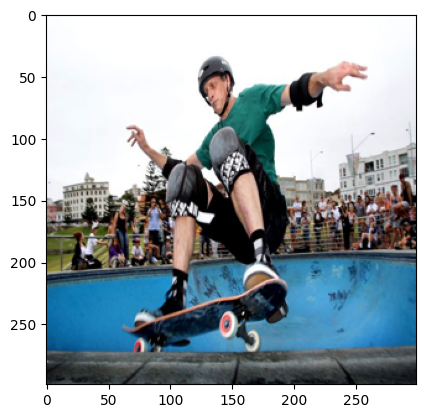

In [ ]:
#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread("img.jpg")
img = np.array(Image.fromarray(img).resize((299, 299)), dtype="float32") / 255.
plt.imshow(img);

In [ ]:
for i in range(10):
    print(' '.join(generate_caption(img, temp=0.6)))

a person riding a skateboard jumping on a large skateboard . [EOS]
a man standing on a skateboard on a skateboard . [EOS]
a person is on a skateboard trick on a park . [EOS]
a person on a skateboard in a field of a skateboard . [EOS]
a young man playing a skateboard on a skateboard [EOS]
a man riding a skateboard and a trick on a skateboard . [EOS]
a man on a skateboard is riding on the skate board . [EOS]
a man is walking down the side of a street . [EOS]
a man riding a skateboard in a park . [EOS]
a young boy rides a skateboard while riding a skateboard . [EOS]


--2024-03-06 14:59:09--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 162.159.135.42
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2024-03-06 14:59:10--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img_1.jpg’

img_1.jpg           100%[===================>] 104.37K   325KB/s    in 0.3s    

2024-03-06 14:59:11 (325 KB/s) - ‘img_1.jpg’ saved [106870/106870]

a black cat sitting on a bench in a room . [EOS]
a cat laying on a black and white cat with a pot . [EOS]
a cat with a black bear on top of a window . [E

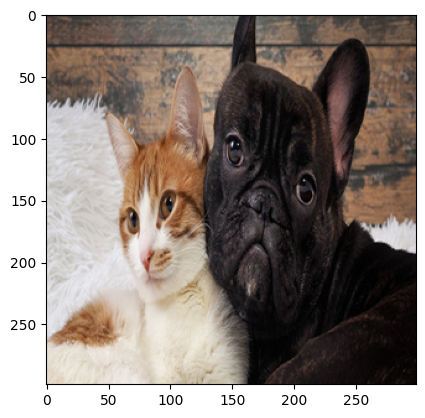

In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img_1.jpg
img = plt.imread("img_1.jpg")
img = np.array(Image.fromarray(img).resize((299, 299)), dtype="float32") / 255.

plt.imshow(img);

for i in range(10):
    print(' '.join(generate_caption(img, temp=0.6)))

Наконец, реализуем Beam-search и примените его для генерации.

In [ ]:
from dataclasses import dataclass, field

@dataclass
class Candidate:
    """ Класс кандидата, содержащий сгенерированный префикс и его скор """
    generated_text: list[str] = field(default_factory=list)
    log_prob_score: float = 0.


def beam_search(
    image,
    max_tokens=100,
    beam_size=4
):
    """
    Генерация описаний изображений c использованием Beam Search.

    Параметры.
    1) image - изображение в формате RGB,
    2) max_tokens - максимальное количество токенов в итоговом описаний,
    3) beam_size - размер beam_size, то есть кол-во рассмтриваемых гипотез
    """
    # отключим вычисление градиентов
    with torch.inference_mode():
        # преобразуем изображение в тензор
        image = torch.FloatTensor(image.transpose([2, 0, 1])).cuda()
        vectors_neck = vectorizer_model(image[None])

        # массивы пустых кандидатов
        candidates = [Candidate()]

        for _ in range(max_tokens):
            updated_candidates = []
            for candidate in candidates:
                # пытаемся продлить каждого кандидата
                # если уже сгенерировали [EOS] – этого кандидата не рассматрвиаем
                if (
                    len(candidate.generated_text)
                    and candidate.generated_text[-1] == "[EOS]"
                ):
                  updated_candidates.append(candidate)
                  continue
                # наш токенизатор сразу добавляет [BOS] и [EOS]
                prefix_ix = tokenizer.encode(" ".join(candidate.generated_text)).ids[:-1]
                prefix_ix = torch.cuda.LongTensor([prefix_ix])
                # вычисляем логиты и лог-вероятности всех токенов словаря
                next_word_logits = caption_net.forward(vectors_neck.cuda(), prefix_ix)[0, -1]
                next_word_log_probs = F.log_softmax(next_word_logits, dim=-1).detach().cpu()
                # оставим beam_size наиболее вероятных продолжений кандидата
                top_k_logp, top_k_indices = torch.topk(next_word_log_probs, k=beam_size)
                top_k_logp, top_k_indices = top_k_logp.numpy(), top_k_indices.numpy()
                # обновлем возможных кандидатов, подсчитывая их скор
                for next_word_logp, next_word_ind in zip(top_k_logp, top_k_indices):
                    next_word = tokenizer.id_to_token(next_word_ind)
                    generated_text = candidate.generated_text + [next_word]
                    # инкрементально обновляем среднее log probs - наш скор
                    log_prob_score = candidate.log_prob_score + \
                     (next_word_logp - candidate.log_prob_score) / len(generated_text)
                    # добавляем кандидата
                    updated_candidates.append(
                        Candidate(generated_text=generated_text, log_prob_score=log_prob_score)
                    )

            # если кандидатов слишком много, то избавимся от менее вероятных
            candidates = sorted(updated_candidates, key=lambda x: x.log_prob_score)[-beam_size:]
        # отсортируем и вернем самого вероятного кандидата
        updated_candidates.sort(key=lambda x: x.log_prob_score)
        return updated_candidates[-1].generated_text

Проверим работу, сравнив жадную генерацию с реализованным Beam Search с beam_size = 1

In [ ]:
generate_caption(img, sample=False), beam_search(img, beam_size=1)

(['a',
  'cat',
  'is',
  'laying',
  'on',
  'a',
  'bed',
  'with',
  'a',
  'cat',
  '.',
  '[EOS]'],
 ['a',
  'cat',
  'is',
  'laying',
  'on',
  'a',
  'bed',
  'with',
  'a',
  'cat',
  '.',
  '[EOS]'])

Действительно, результаты совпадают. Посмотрим на пример beam_size > 1.

In [ ]:
beam_search(img, beam_size=5)

['a',
 'cat',
 'laying',
 'on',
 'a',
 'bed',
 'next',
 'to',
 'a',
 'window',
 '.',
 '[EOS]']